<a href="https://colab.research.google.com/github/59822/Decision-tree/blob/main/svm_heart_dsie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("johnsmith88/heart-disease-dataset")

print("Path to dataset files:", path)

100%|██████████| 6.18k/6.18k [00:00<00:00, 2.88MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/johnsmith88/heart-disease-dataset/versions/2


In [2]:
import os
import shutil

basename = os.path.basename(path)
desti = '/content/'+basename

if not os.path.exists(desti):
  shutil.move(path,desti)
  print("Ok")
else:
  print("Ya")

Ok


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn


In [4]:
dt = pd.read_csv("/content/2/heart.csv")
dt

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [7]:
dt.columns
'''
age
sex
chest pain type (4 values)
resting blood pressure
serum cholestoral in mg/dl
fasting blood sugar > 120 mg/dl
resting electrocardiographic results (values 0,1,2)
maximum heart rate achieved
exercise induced angina
oldpeak = ST depression induced by exercise relative to rest
the slope of the peak exercise ST segment
number of major vessels (0-3) colored by flourosopy
thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
'''

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [13]:
## Borrar datos nulos

dt.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


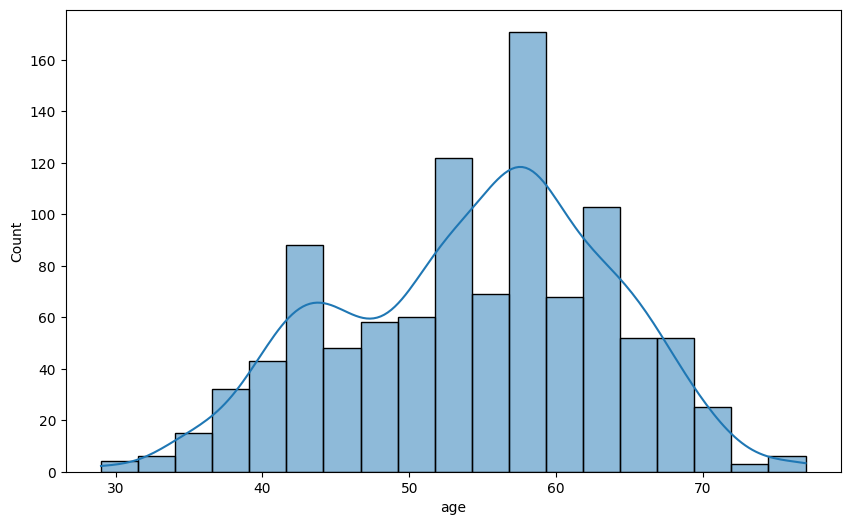

In [14]:
# Analizar la realción de edades

plt.figure(figsize=(10,6))
sns.histplot(data = dt['age'], kde=True)
plt.show()

In [16]:
media = dt['age'].mean()
print(round(media,2))

54.43


In [21]:
desv = dt['age'].to_numpy()
desviacion = desv.std()
print(desviacion)

9.067863645894516


In [25]:
dt.dtypes

,0
age,int64
sex,int64
cp,int64
trestbps,int64
chol,int64
fbs,int64
restecg,int64
thalach,int64
exang,int64
oldpeak,float64


In [29]:
sex_freq = dt.groupby('sex')['sex'].count()
sex_freq

,sex
sex,
0,312
1,713


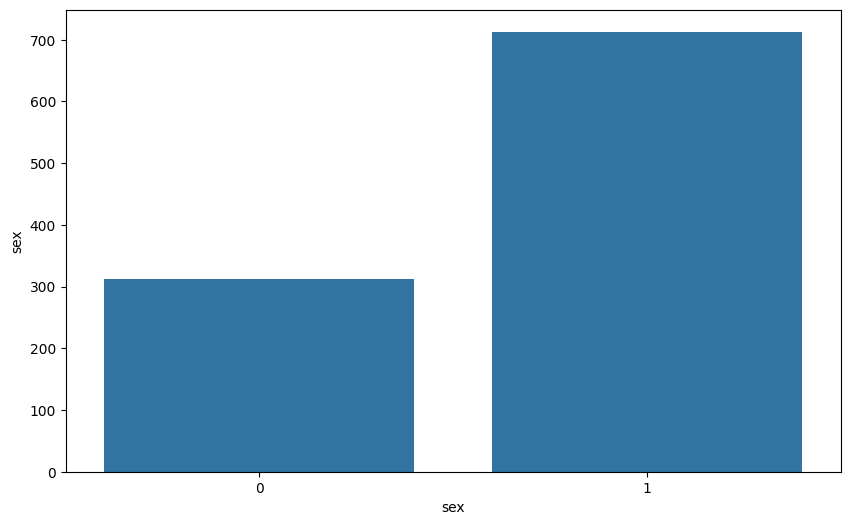

In [30]:

plt.figure(figsize=(10,6))
sns.barplot(sex_freq)
plt.show()

In [44]:
# V amois a ver la relación de todas las variables, númericas y categoricas

from scipy.stats import chi2_contingency, ttest_ind, f_oneway
from scipy.stats import pearsonr


def calcular_relacion(x, y):
    """Calcula la relación entre dos variables usando la prueba apropiada."""
    if pd.api.types.is_numeric_dtype(x) and pd.api.types.is_numeric_dtype(y):
        # Para variables numéricas, usa correlación de Pearson
        corr, _ = pearsonr(x, y)
        return corr
    elif pd.api.types.is_categorical_dtype(x) and pd.api.types.is_categorical_dtype(y):
        # Para variables categóricas, usa chi-cuadrado
        tabla_contingencia = pd.crosstab(x, y)
        chi2, p_valor, _, _ = chi2_contingency(tabla_contingencia)
        # Retorna el p-valor de chi-cuadrado
        return p_valor
    elif pd.api.types.is_numeric_dtype(x) and pd.api.types.is_categorical_dtype(y):
        # Para numérica vs categórica, usa t-student o ANOVA
        grupos = y.unique()
        if len(grupos) == 2:
            # Si la categórica tiene 2 grupos, usa t-student
            grupo1 = x[y == grupos[0]]
            grupo2 = x[y == grupos[1]]
            _, p_valor = ttest_ind(grupo1, grupo2)
            return p_valor
        else:
            # Si la categórica tiene más de 2 grupos, usa ANOVA
            grupos_data = [x[y == g] for g in grupos]
            _, p_valor = f_oneway(*grupos_data)
            return p_valor
    elif pd.api.types.is_categorical_dtype(x) and pd.api.types.is_numeric_dtype(y):
        # Para categórica vs numérica, también usa t-student o ANOVA
        # Invierte el orden de las variables y llama a la función recursivamente
        return calcular_relacion(y, x)
    else:
        # Si las variables no son compatibles, retorna NaN
        return np.nan



columnas = dt.columns

# Crea una matriz vacía para almacenar las correlaciones
matriz_correlacion = pd.DataFrame(index=columnas, columns=columnas)

# Calcula las correlaciones para cada par de variables
for i in columnas:
    for j in columnas:
        matriz_correlacion.loc[i, j] = calcular_relacion(dt[i], dt[j])

print(matriz_correlacion)

               age       sex        cp  trestbps      chol       fbs  \
age            1.0  -0.10324 -0.071966  0.271121  0.219823  0.121243   
sex       -0.10324       1.0 -0.041119 -0.078974 -0.198258    0.0272   
cp       -0.071966 -0.041119       1.0  0.038177 -0.081641  0.079294   
trestbps  0.271121 -0.078974  0.038177       1.0  0.127977  0.181767   
chol      0.219823 -0.198258 -0.081641  0.127977       1.0  0.026917   
fbs       0.121243    0.0272  0.079294  0.181767  0.026917       1.0   
restecg  -0.132696 -0.055117  0.043581 -0.123794  -0.14741 -0.104051   
thalach  -0.390227 -0.049365  0.306839 -0.039264 -0.021772 -0.008866   
exang     0.088163  0.139157 -0.401513  0.061197  0.067382  0.049261   
oldpeak   0.208137  0.084687 -0.174733  0.187434   0.06488  0.010859   
slope    -0.169105 -0.026666  0.131633 -0.120445 -0.014248 -0.061902   
ca        0.271551  0.111729 -0.176206  0.104554  0.074259  0.137156   
thal      0.072297  0.198424 -0.163341  0.059276  0.100244 -0.04

In [35]:
?chi2_contingency

In [48]:
# Encontrar outliers con box plot

Q1_edad = dt['age'].quantile(0.25)
Q3_edad = dt['age'].quantile(0.75)

IQR = Q3_edad - Q1_edad
limite_superior = Q3_edad + 1.5 * IQR
limite_inferior = Q1_edad - 1.5 * IQR

outliers = dt[(dt['age'] > limite_superior) | (dt['age'] < limite_inferior)]
print(outliers) # No hay nada help

Empty DataFrame
Columns: [age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal, target]
Index: []


In [ ]:
# https://chatgpt.com/g/g-p-679e8873ed388191b8d250f3313c28bd-op/c/67aa59b1-db78-800c-a16f-a9f02676f0b9
#https://chatgpt.com/g/g-p-679e8873ed388191b8d250f3313c28bd-op/c/67aa59b1-db78-800c-a16f-a9f02676f0b9